In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
env = gym.envs.make("MountainCar-v0")

[2017-02-13 11:05:48,745] Making new env: MountainCar-v0


In [3]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [4]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If a state a is given this returns a single number as the prediction.
            If no state is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        # TODO: Implement this!
        features = self.featurize_state(s)
        if not a:
            return np.array([m.predict([features])[0] for m in self.models])
        else:
            return self.models[a].predict([features])[0]
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])
        

In [5]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [7]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    #matplotlib.pyplot.figure()
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        
        last_reward = stats.episode_rewards[i_episode - 1]
        print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward))
        sys.stdout.flush()
        # Initialize S
        state = env.reset()
        #done = False
        
        for t in itertools.count():
            # Choose A from S using policy derived from Q
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            
            next_values = estimator.predict(next_state)
            
            td_target = reward + discount_factor*np.max(next_values)
            estimator.update(state, action, td_target)
            
            #matplotlib.pyplot.imshow(env.render(mode='rgb_array'))
            
            
            if done:
                print("\rSteps {} in Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward))
                break
                env.render(close=True)
            state = next_state
        
        # TODO: Implement this!
    #env.render(close=True)
    matplotlib.pyplot.close()
    return stats

In [8]:
estimator = Estimator()

In [10]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
stats = q_learning(env, estimator, 100, epsilon=0.0)

Episode 1/100 (0.0)
Steps 365 in Episode 1/100 (0.0)
Episode 2/100 (-366.0)
Steps 484 in Episode 2/100 (-366.0)
Episode 3/100 (-485.0)
Steps 253 in Episode 3/100 (-485.0)
Episode 4/100 (-254.0)
Steps 219 in Episode 4/100 (-254.0)
Episode 5/100 (-220.0)
Steps 231 in Episode 5/100 (-220.0)
Episode 6/100 (-232.0)
Steps 206 in Episode 6/100 (-232.0)
Episode 7/100 (-207.0)
Steps 304 in Episode 7/100 (-207.0)
Episode 8/100 (-305.0)
Steps 240 in Episode 8/100 (-305.0)
Episode 9/100 (-241.0)
Steps 238 in Episode 9/100 (-241.0)
Episode 10/100 (-239.0)
Steps 188 in Episode 10/100 (-239.0)
Episode 11/100 (-189.0)
Steps 169 in Episode 11/100 (-189.0)
Episode 12/100 (-170.0)
Steps 381 in Episode 12/100 (-170.0)
Episode 13/100 (-382.0)
Steps 260 in Episode 13/100 (-382.0)
Episode 14/100 (-261.0)
Steps 157 in Episode 14/100 (-261.0)
Episode 15/100 (-158.0)
Steps 159 in Episode 15/100 (-158.0)
Episode 16/100 (-160.0)
Steps 154 in Episode 16/100 (-160.0)
Episode 17/100 (-155.0)
Steps 182 in Episode 17/

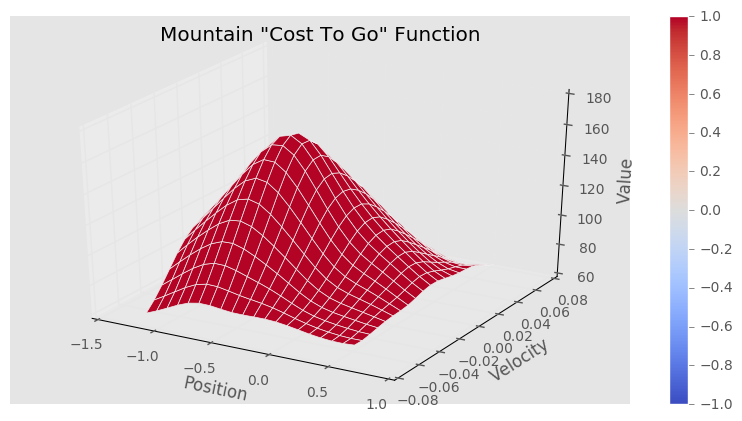

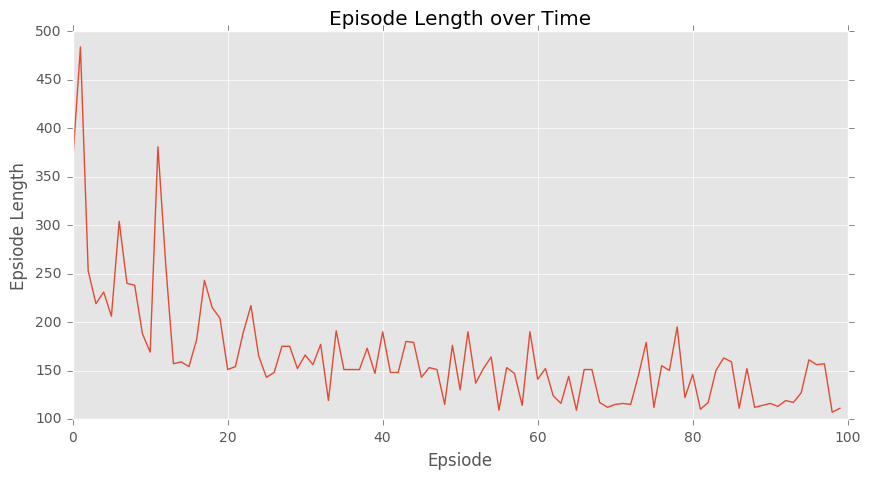

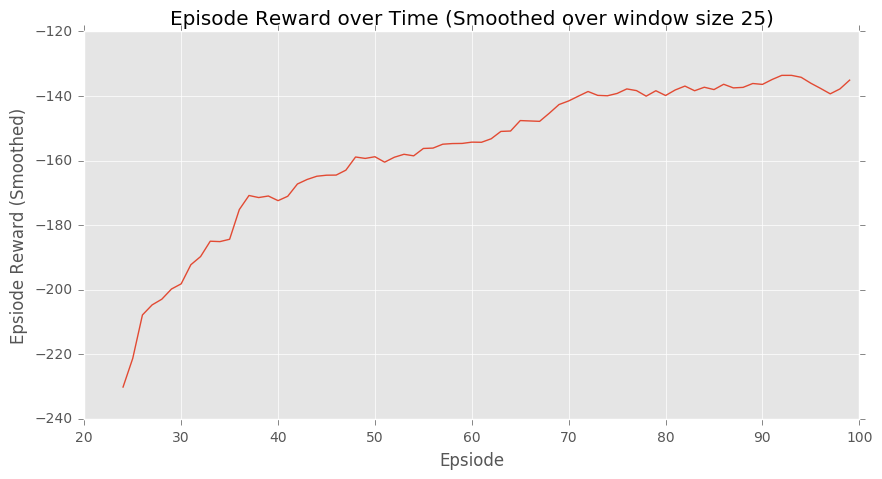

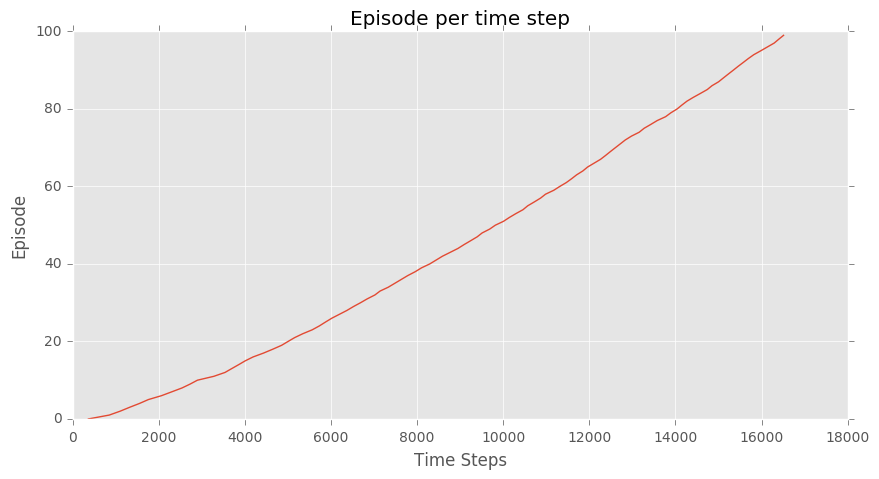

(<matplotlib.figure.Figure at 0x7f33a3f0b7d0>,
 <matplotlib.figure.Figure at 0x7f33a1397ad0>)

In [11]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)

In [10]:
env.render(close=True)

In [12]:
estimator.models

[SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
        fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
        loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
        random_state=None, shuffle=True, verbose=0, warm_start=False),
 SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
        fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
        loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
        random_state=None, shuffle=True, verbose=0, warm_start=False),
 SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
        fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
        loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
        random_state=None, shuffle=True, verbose=0, warm_start=False)]

In [13]:
a = estimator.models[0]

In [14]:
b = estimator.models[1]
c = estimator.models[2]

In [17]:
a.partial_fit?

In [20]:
state = env.reset()
print state

[-0.43881875  0.        ]


In [23]:
next_state, reward, done, _ = env.step(1)

In [24]:
next_state

array([-0.43944776, -0.00062902])

In [26]:
estimator.predict(next_state)

array([-159.22541019, -159.17222364, -158.8937394 ])

In [28]:
scaled = scaler.transform([next_state])

In [30]:
print next_state
print scaled

[-0.43944776 -0.00062902]
[[-0.24697958 -0.00606258]]


In [31]:
feats = featurizer.transform(scaled)

In [33]:
feats.shape

(1, 400)

In [34]:
featurizer.get_feature_names

<bound method FeatureUnion.get_feature_names of FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)>

In [35]:
featurizer.transformer_list

[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)),
 ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)),
 ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)),
 ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))]

In [36]:
featurizer.transformer_weights

In [37]:
rb = RBFSampler?

In [39]:
rb = RBFSampler(gamma=1.0, n_components=10)

In [40]:
rb.fit_transform?

In [43]:
rb.fit_transform([next_state])

array([[ 0.26264923,  0.43858927,  0.31521414, -0.42106848,  0.09723709,
        -0.3670266 , -0.20645908,  0.33826878,  0.17618622,  0.14283844]])